Approach:

-Import photos  
-Rotate & Crop photos  
-Put date and time on each photo (decided not to use in the end)  
-Normalize darkness during night (decided not to use in the end)  

In [1]:
#Import libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from matplotlib.pyplot import imshow
import numpy as np
import os.path, time
from tqdm import tqdm
import glob
import uuid
from moviepy.editor import *
from shutil import copyfile

%matplotlib inline

# Install a pip package in the current Jupyter kernel
# Install Pillow so matplotlib can handle jpg files
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pillow
from PIL import Image, ImageDraw, ImageFont, ImageStat
!{sys.executable} -m pip install --upgrade setuptools
!{sys.executable} -m pip install moviepy

Requirement already up-to-date: pip in /opt/ds/lib/python3.4/site-packages (18.0)
Requirement already up-to-date: setuptools in /opt/ds/lib/python3.4/site-packages (40.0.0)


## Import photo and see it

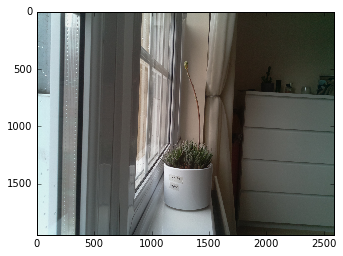

In [12]:
def import_and_see(image):
    #reading in an image as a PIL because it's faster to rotate photos, later we convert images to np
    im = Image.open(image)
    #printing out some stats and plotting
    #print('This image is:', type(im), 'with dimesions:', im.size)
    return im

im=import_and_see('./1. Test_Prep_Fonts/test.jpg')
imshow(np.asarray(im))

## Rotate & crop image

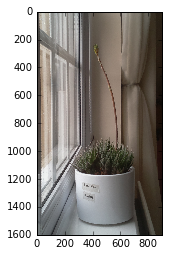

In [13]:
def rot_crop(im):
    #Rotate photo X degrees
    im=im.rotate(3)

    #Convert PIL im to np Image
    im=np.array(im)

    # #Invert Axis (it's just more intuitive for me)
    x_max=im.shape[1]
    y_max=im.shape[0]

    x_crop_start=850
    x_crop_end=1750

    y_crop_start=200
    y_crop_end=1800

    cropped_image =im[y_crop_start: y_crop_end, x_crop_start: x_crop_end]
    return cropped_image

im=rot_crop(im)
imshow(np.asarray(im))

## Write date & time in photo (decided not to use in the end)

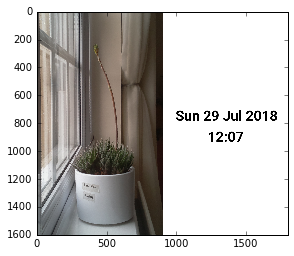

In [14]:
def write_in_photo(im):
    #Convert back to PIL -> to be able to write on image
    im = Image.fromarray(im.astype('uint8'), 'RGB')

    #create new "image" with the same size as the original where we are going to put the text
    background_color=(255,255,255)
    text_image = Image.new('RGB', (im.size[0],im.size[1]), color = background_color)

    #Position of the text + Font
    text_position_line1=(90,690)
    text_position_line2=(320,840)
    fnt = ImageFont.truetype("./1. Test_Prep_Fonts/Roboto-Bold.ttf",100)
    d = ImageDraw.Draw(text_image)

    #what to write on image?
    #In this case I want to write the creation/modified date of the image
    #For that, first I need to extract that info from the image
    time_stamp=time.ctime(os.path.getmtime("./1. Test_Prep_Fonts/test.jpg")).split()
    # print("created: %s" % time.ctime(os.path.getctime("./1. Test_Prep_Fonts/test.jpg")))
    # time_stamp = 'Sun Jul 29 12:07:01 2018'

    #Create 2 lines of text, one with date, other with time
    what_to_write_line_1=time_stamp[0]+" "+time_stamp[2]+" "+time_stamp[1]+" "+time_stamp[4]
    what_to_write_line_2=time_stamp[3][:-3]

    d.text(text_position_line1, what_to_write_line_1, font=fnt, fill=(0,0,0))
    d.text(text_position_line2, what_to_write_line_2, font=fnt, fill=(0,0,0))

    #Merge image and text_image together
    images = [im, text_image]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]

#     plt.imshow(new_im)
    return new_im

im=write_in_photo(im)
imshow(np.asarray(im))



## Normalize darkness during night (decided not to use in the end)

In [126]:
# Source: https://stackoverflow.com/questions/3490727/what-are-some-methods-to-analyze-image-brightness-using-python

PATH= "./"    
search_dir=PATH+"2. Processed_Photos/"

#calcula a media do brilho do histograma para a imagem givem
def brightness(im_file):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))   #this is a way of averaging the r g b values to derive "human-visible" brightness

#stora no myList a media dos histogramas para cada imagem
myList = [0.0]
b = 0.0
num_images = len(getfiles(search_dir)) # number of images in the list

# loop to auto-generate image names and run prior function
for i in getfiles(search_dir):
    myList.append(brightness(search_dir+i))

#calcula a media dos brilhos medios
avg_brightness = sum(myList[1:])/num_images
# print(myList)
# print(avg_brightness)

#calcula a diferenca do brilho medio do histograma para o brilho medio da media dos histogramas
#se a foto estiver mais clara que a media o valor e negativo, se for positivo provavelmente significa que esta de noite
deltaList = [0.0]
for i in myList:
   deltaList.append(avg_brightness - i)

# print(deltaList)


#For each photo see if they are too dark (deltaList value<30), if yes, bring the photos closer to the average
for idx, k in enumerate(getfiles(search_dir)):
    new_image_name = PATH+"2.1 Processed_Photos_brightness adjusted/image_brightadj_-"+str("%04d" % idx)+".jpg"
    if deltaList[idx]>30:
        img_file = Image.open(search_dir+k)
        img_file = img_file.convert('RGB')     # converts image to RGB format
        pixels = img_file.load()               # creates the pixel map
        for i in range (img_file.size[0]):
           for j in range (img_file.size[1]):
              r, g, b = img_file.getpixel((i,j))  # extracts r g b values for the i x j th pixel
              pixels[i,j] = (r+int(deltaList[idx]/3), g+int(deltaList[idx]/3), b+int(deltaList[idx]/3)) # re-creates the image  
        j = str(idx)
        img_file.save(new_image_name)
    else:
        copyfile(search_dir+k, new_image_name)


In [35]:
# Put all together (import, rotate, crop and save them to a new folder)

def go(im,fname):
    im=import_and_see(im) 
    im=rot_crop(im)
    im = Image.fromarray(im.astype('uint8'), 'RGB')
    
    PATH= "./"        
    rgb_im = im.convert('RGB')
    rgb_im.save(PATH+"2. Processed_Photos/image-"+str("%04d" % fname)+".jpg")


PATH= "./"    
search_dir=PATH+"0. TimeLapse_Aloe_photos/"

#get files from the photos folder and sort them by modified date
def getfiles(dirpath):
    a = [s for s in os.listdir(dirpath)
         if os.path.isfile(os.path.join(dirpath, s))]
    a.sort(key=lambda s: os.path.getmtime(os.path.join(dirpath, s)))
    return a


#Apply rotate and crop to all the photos
for idx, photos in enumerate(getfiles(search_dir)):
#     print(idx)
#     print(photos)
    if '.jpg' in photos:
        go(search_dir+photos,idx)


## Make a movie out of the photos

In [134]:
#Source folder: Where all the photos are
PATH= "./"    
search_dir=PATH+"2. Processed_Photos/"

#Create a list with all the photos paths
all_photos=getfiles(search_dir)
all_photos_with_path=[]

for i in all_photos:
    all_photos_with_path.append(search_dir+i)   

#Create and save video
clip = ImageSequenceClip(all_photos_with_path, fps=35)
clip.write_videofile("./timelapse.mp4",audio=False)



[MoviePy] Building file ./1. Lace_Aloe_TimeLapse/nonorm_35.gif with imageio



100%|██████████| 1995/1995 [12:13<00:00,  2.72it/s]
